# Task 2

## Problem
1) Build the following simple circuit to prepare the Bell state:
<img src="images/1.png">

2) Now add, right before the CNOT gate and for each of the two qubits, an arbitrary “error gate”. By error gate we mean that with a certain probability (that you can decide but must be non-zero for all the choices) you have a 1 qubit unitary which can be either the identity, or the X gate (bit-flip error) or the Z gate (sign-flip error).

3) Encode each of the two qubits with a sign-flip or a bit-flip code, in such a way that all the possible choices for the error gates described in 2), occurring on the logical qubits, can be detected and fixed. Motivate your choice.

4) Test your solution by making many measurements over the final state and testing that the results are in line with the expectations.


## Overview of my solution
Initially, 2 assumptions are made. <br>
Assumption-1: Error probabilities are small s.t. the probability of more than a single qubit being affected is negligible <br>
Assumption-2: Error can act only on the main qubit (and not on ancillary qubits) <br> <br>

For analyzing a solution, we do 3 tests on the solution: <br>
Test-1: Assuming both assumptions 1 and 2 hold. <br>
Test-2: Assumption 1 holds, assumption 2 is removed (more general than test-1) <br>
Test-3: Both assumptions 1 and 2 are removed. (most general) <br> <br>

We will see, our 1st solution works well on Test-1 but fails on test-2. <br>
We then define our 2nd solution and test it on tests-1,2 and 3. <br> <br>

At the end, as additional work, I have presented a very efficient 2 qubit error detector (not error corrector)

## Pattern of this solution

Section 1 <br>
    1.1 - Building the given circuit <br>
    1.2 - Defining helper functions <br><br>
Section 2 - Adding error gates and looking at the resulting final states <br><br>
Section 3 - Initial Assumptions (which will later be relaxed) <br>
    Assumption-1 <br>
    Assumption-2
     <br><br>
Section 4 - Error correction <br>
    4.1 - Solution-1: Error correction method using two Bit-flip codes and one Sign-flip code (uses 6 additional qubits) <br>
    4.2 - Solution-2: Error correction method using three Bit-flip and two Sign-flip codes. (uses 10 additional qubits) <br>
<br>

Section 5 - (Bonus work) Very Efficient Error DETECTION <br>
    5.1 - An even better method to DETECT error (using only 2 additional qubits)

In [1]:
#install/upgrade the dependencies
#!pip install --upgrade qiskit==0.23.4

In [2]:
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import pauli_error
from collections import defaultdict
from qiskit import Aer
import numpy as np
import matplotlib.pyplot as plt

## Section 1 - Building specified circuit

Let's first make the specified circuit to prepare the bell states. We will be using the qiskit library.

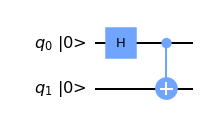

In [3]:
q=QuantumRegister(2,'q')
circuit = QuantumCircuit(q)
circuit.h(0)
circuit.cx(0,1)
circuit.draw(initial_state=True, output="mpl")

The resulting bell state is (|00> + |11>)/√2 . So if we run this circuit many times and measure the values, we should get an equal number of |00> and |11> states. Let's do that.

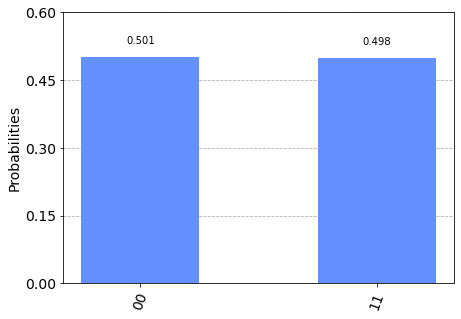

In [4]:
simulator = Aer.get_backend('qasm_simulator')
circuit.measure_all()
job = execute(circuit, simulator, shots=10000)
result = job.result()
counts = result.get_counts(circuit)
plot_histogram(counts)

The code in the previous cell will be needed throughout the notebook. So its better to define some helper functions to call such code easily multiple times.

### Helper Functions

In [5]:
def state_count(circuit): #Helper function to run the circuit multiple times and return the counts of different states
    simulator = Aer.get_backend('qasm_simulator')
    ct=circuit.copy()
    ct.measure_all()
    job = execute(ct, simulator, shots=1000)
    result = job.result()
    counts = result.get_counts(ct)
    return counts

def get_counts(circuit): #Helper function to return the count of top two qubits which we are concerned about.
    ct=circuit.copy()
    counts=state_count(ct)
    count_dict=defaultdict(int)
    for i in counts:
        count_dict[i[-2:]]+=counts[i] #Picking last two qubits
    return count_dict

The above functions help us measure the qubits and return the count of different valued qubits. However, they do not tell us about the exact state (with superposition and phase). <br><br>
For example - they will treat |00>+|11>  and  |00>-|11> as same states while counting.
<br><br>
For exact state, we need to use get_statevector function from the 'statevector_simulator' simulator. Let's define helper functions for exact state.

The following two helper functions allow us to get circuit output in a particular format that later helps making analysis part easier.

In [6]:
def comb(a): #Adds every 4th element of the list. Returns a list of length 4.
    S1,S2,S3,S4=0,0,0,0
    for i in range(len(a)//4):
        S1=S1+a[i*4]   # S1=a[0]+a[4]+a[8]+....
        S2=S2+a[i*4+1] # S2=a[1]+a[5]+a[9]+...
        S3=S3+a[i*4+2]
        S4=S4+a[i*4+3]
    return [S1,S2,S3,S4]

#Why this function? - 
#get_statevector returns a list of states for all qubits. However we are only concerned about first two qubits.
#So, we define a function (named "comb", defined above) that transforms the 4*n length list to a list of length 4,
#representing state of our first 2 qubits,
#that is in terms of, 00, 01, 10, 11

#Basically above fn condenses, say, (000+001+010+011+100+101+110+111) to -> (00+01+10+11) by adding corresponding coefficients.

In [7]:
def exact_statevector(circuit): #returns a list of possible states of the 2 target qubits (with sign)
    backend = Aer.get_backend('statevector_simulator')
    state = execute(circuit, backend).result()
    a=state.get_statevector(decimals=3)
    a=comb(a) #combines every 4th element to transform the list as per our requirements.
    ll=["00","01","10","11"]  #4 states we are concerned with.
    alist=[]
    #below "if statement" helps converting states like -|00>-|11> to +|00>+|11> (for better analysis from histograms)
    if a[0].real<0 or (a[0].real==0 and a[1].real<0) or (a[0].real==0 and a[1].real==0 and a[2].real<0): 
        a=np.negative(a)
    for i in range(4): #appending corresponding element and adding sign (+/-) using string formatting.
        if a[i].real<-0.01:
            alist.append("-"+ll[i])
        elif a[i].real>0.01:
            alist.append("+"+ll[i])    
    return alist

For our basic bell state circuit, the above function will return the list - ['+00', '+11'] <br>
Note-For simple presentation, we have dropped the value of coeffcients of qubits. <br>
For all our tasks, we will only be needing the "sign" of coefficients which we have preserved. <br>
Reason- there are no phase changes (except phase flips which have been addressed by preserving sign) in the whole problem <br>

This might seem very troubling as of now, but later while analyzing things, this will come in handy.

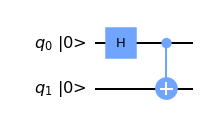

In [8]:
q=QuantumRegister(2,'q')
circuit = QuantumCircuit(q)
circuit.h(0)
circuit.cx(0,1)
circuit.draw(initial_state=True, output="mpl")

In [9]:
exact_statevector(circuit)

['+00', '+11']

In [10]:
#For the task where the error gate will apply the type of error based on the probability value p, we will need to run
#that code many times to get the idea of expected results.
#For that, we define a helper function which counts and returns the state after 10000 runs
def state_frequency(circuit):
    dd=defaultdict(int)
    for i in range(10000):
        al=tuple(exact_statevector(circuit))
        dd[al]+=1
    return dd

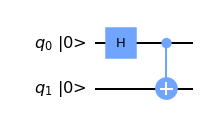

In [11]:
circuit.draw(initial_state=True, output="mpl")

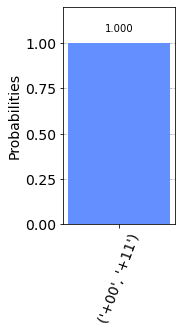

In [12]:
count=state_frequency(circuit)
plot_histogram(count,figsize=(2,4))

## Section 2 - Adding error gates

Let's now add the specified error gates and then we'll look at the resulting final states. To make it more general, we will add two separate error gates to each of the qubits.

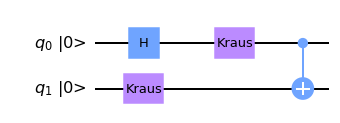

In [13]:
q=QuantumRegister(2,'q')
circuit = QuantumCircuit(q)
circuit.h(0)

E1=pauli_error([('X',0.15),('I',0.7),('Z',0.15)], standard_gates=True) #Error gate I=No error, X=Bit Flip , Z=Sign Flip
E2=pauli_error([('X',0.15),('I',0.7),('Z',0.15)], standard_gates=True) #Error gate
circuit.append(E1, [0])
circuit.append(E2, [1])

circuit.cx(0,1)
circuit.draw(initial_state=True, output="mpl")

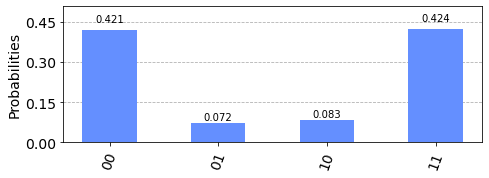

In [14]:
#Let's try plotting the measured values instead of the exact state vector
counts=get_counts(circuit)
plot_histogram(counts,figsize=(7.5, 2.5))

We can't use (count of 00 + count of 11) as our accuracy measure as some of them might be coming from state 00-11 <br>
That's why we defined those helper functions to get exact statevectors.<br>
Let's now see the exact statevectors resulting from this circuit.

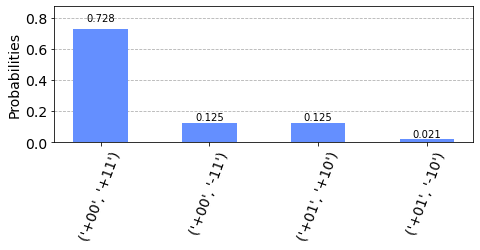

In [15]:
count=state_frequency(circuit)
plot_histogram(count,figsize=(7.5, 2.5))

So, under these errors, our circuit can only return 4 states: <br>
00+11, 00-11, 01+10, 01-10 <br>

In the case of no error, we get all of our states in 00+11

## Section 3 - Initial Assumptions (which will later be removed)


### Assumption-1: 
Error probabilities are small s.t. the probability of more than a single qubit being affected is negligible <br>

### Assumption-2: 
Error can act only on the main qubit (and not on ancillary qubit) <br><br>

We will discuss error correction in section 4. For testing our solution, initially we will assume a very specific scenario (where both assumption 1 & 2 hold). Then, as we move on, we will relax these assumptions one-by-one and by the end of section-4.2 we will be testing our solution on the most general case (error can act on multiple qubits at once & error can act on ancillary qubits as well.
     <br><br>

Definitions: <br>
Test-1: Only 1st qubit and 2nd qubit can have errors. { either I (no error) or X (bitflip) or Z (signflip) } <br>
Basically Test-1 will be the testing of our error correction circuit for the case where both assumptions hold. <br> <br>

Test-2: Any qubit (ancillary as well) can have error. But, only two qubits (one each for 1st error gate and 2nd error gate) can have error at once. <br>
Basically Test-2 will be the testing of our error correction circuit for the case where only 1st assumption holds. <br> <br>

Test-3: Any number of qubits can have error. (i.e. the most general case where neither of the 2 assumptions hold)


## Section 4 - Error Correction



### Section 4.1 :  Error correction method using Bit flip and Sign flip code (Solution-1)
Uses 6 additional qubits


Let's first analyze the circuit in question

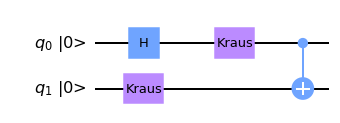

In [16]:
circuit.draw(initial_state=True, output="mpl")

Looking at the first qubit, we are first applying Hadamard gate and after that the error is applied. The output from Hadamard gate is a |+> qubit which remains indifferent under the effect of a bit-flip error. Thus, we only need to address the sign flip error for the first qubit. So we will apply a sign-flip code on 1st qubit. <br><br>
However, if a bit-flip error occurs on our sign-flip code (even on the logical qubit), it disturbs our sign-flip code. Hence, we will first apply a bit-flip code on 1st qubit, and over that, we will apply a sign-flip code.<br><br>
Similarly, for the second qubit, the state entering the error is |0> which remains indifferent under the effect of a sign flip error. Thus, we only need to address the bit flip error for the second qubit. Also, the bit-flip code isn't affected by sign flips, so we don't need any additional code for this qubit. <br><br><br>



Basically, <br>
we will apply a bit-flip code on 1st qubit, a sign-flip code on 1st qubit and a bit-flip code on 2nd qubit. <br>
Total additional qubits needed = 2+2+2=6 <br>
Following figure shows our plan: <br>
<img src="images/44.png">

In [17]:
#Helper function for Bitflip code circuit BEFORE error operation.
def bitflip_before_error():
    circuit = QuantumCircuit(3)
    circuit.cx(0,1) 
    circuit.cx(0,2)
    
    return circuit

#Helper function for Bitflip code circuit AFTER error operation.
def bitflip_after_error():
    circuit = QuantumCircuit(3)
    circuit.cx(0,1) 
    circuit.cx(0,2)
    circuit.ccx(2,1,0)
    
    return circuit

#Helper function for Signflip code circuit BEFORE error operation.
def signflip_before_error():
    circuit = QuantumCircuit(3)
    circuit.cx(0,1) 
    circuit.cx(0,2)
    circuit.h(0)
    circuit.h(1)
    circuit.h(2)
    
    return circuit

#Helper function for Signflip code circuit AFTER error operation.
def signflip_after_error():
    circuit = QuantumCircuit(3)
    circuit.h(0)
    circuit.h(1)
    circuit.h(2)
    circuit.cx(0,1) 
    circuit.cx(0,2)
    circuit.ccx(2,1,0)
    return circuit



In [18]:
#Helper function which -
#1) creates our initial circuit for bell states, 
#2) adds corresponding flip-codes to both our logical qubits
#3) adds desired error to the desired qubit
def bit_sign_circuit(qbno1=-1,typeoferror1="I",qbno2=-1,typeoferror2="I"):  
    circuit = QuantumCircuit(QuantumRegister(2,'q'))
    circuit.h(0)
    circuit.add_register(QuantumRegister(4,'qs1')) #Adding 4 ancillary qubits for 1st qubit
    signcode1=signflip_before_error()
    signcode2=signflip_after_error()
    bitcode1=bitflip_before_error()
    bitcode2=bitflip_after_error()
    circuit=circuit.compose(signcode1,[0,2,3]) #Opening Sign flip code
    circuit=circuit.compose(bitcode1,[0,4,5]) #Adding 1st Bit flip code
    if qbno1>=0 and typeoferror1=="X": #Adding errors
        circuit.x(qbno1)
    elif qbno1>=0 and typeoferror1=="Z":
        circuit.z(qbno1)   
    circuit=circuit.compose(bitcode2,[0,4,5]) #Closing 1st Bit flip code
    circuit=circuit.compose(signcode2,[0,2,3]) #Closing Sign flip code
    circuit.add_register(QuantumRegister(2,'qs2')) #Adding 2 ancillary qubits for 2nd qubit
    circuit=circuit.compose(bitcode1,[1,6,7]) #Opening 2nd Bit flip code
    if qbno2>=0 and typeoferror2=="X": #Adding errors
        circuit.x(qbno2)
    elif qbno2>=0 and typeoferror2=="Z":
        circuit.z(qbno2)
    circuit=circuit.compose(bitcode2,[1,6,7]) #Closing 2nd Bit flip code
    #MAIN CNOT GATE to generate Bell state
    circuit.cx(0,1)
    return circuit

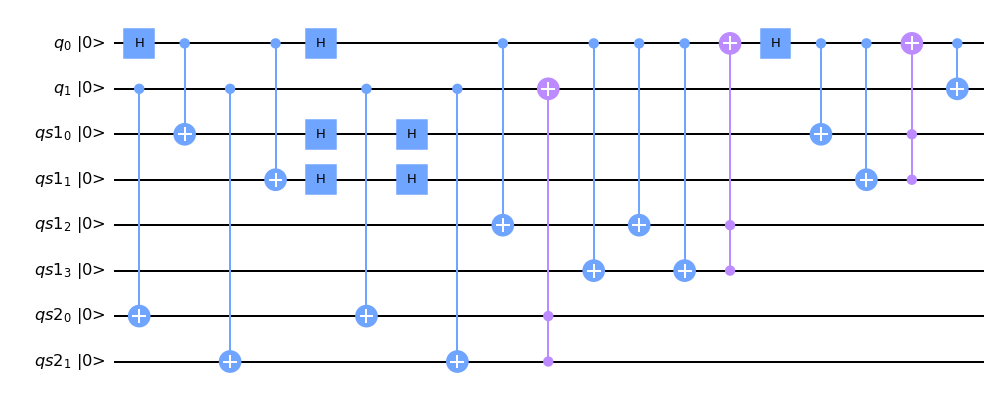

In [19]:
#Let's see the desired circuit
circuit=bit_sign_circuit()
circuit.draw(initial_state=True, output="mpl")

In [20]:
aqb1=[0,2,3,4,5] #qubit nos. corresponding to 1st logical qubit
aqb2=[1,6,7] #qubit nos. corresponding to 2nd logical qubit

### Soln1 : Test-1

Applying error I/X/Z to q_0 and q_1 and analyzing all such (3x3=9) combinations

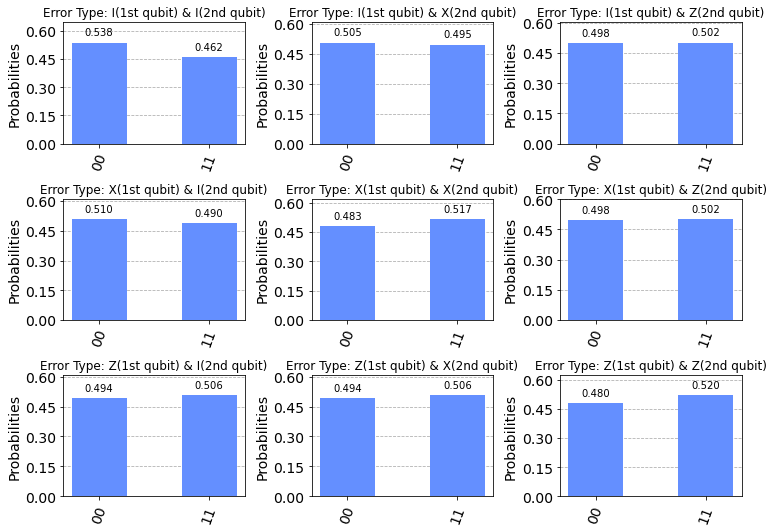

In [21]:
#Now we try all possible combinations of adding error to the two logical qubits 
#i.e. II,IX,IZ,XI,XX,XZ,ZI,ZX,ZZ

error_gates=["I","X","Z"]  #Testing for all possible errors one-by-one
fig=plt.figure(figsize=(10.5, 7.5))
idx=1
for q1error in error_gates:
    for q2error in error_gates:
        circuit=bit_sign_circuit(0,q1error,1,q2error) #Creating circuit
        counts=get_counts(circuit) #Getting the states
        ax=fig.add_subplot(3,3,idx,title="Error Type: "+q1error+"(1st qubit) & "+q2error+"(2nd qubit)")
        plot_histogram(counts,ax=ax)    
        idx+=1
fig.tight_layout()
plt.show() 

Although we got equal 00 and 11 in above graph, we still can't be sure whether they came from 00+11 state or 00-11 state. <br>
For that, let's look at the exact states.

In [22]:
error_gates=["I","X","Z"]
for q1error in error_gates:
    for q2error in error_gates:
        circuit=bit_sign_circuit(0,q1error,1,q2error) #Creating circuit
        print(exact_statevector(circuit)) #Getting the statevector

['+00', '+11']
['+00', '+11']
['+00', '+11']
['+00', '+11']
['+00', '+11']
['+00', '+11']
['+00', '+11']
['+00', '+11']
['+00', '+11']


So we were successfull in out Test-1. Hence our soln 1 is able to solve the problem when those 2 assumptions hold.

### Soln 1 : Test-2

We now remove assumption-2 <br>
i.e. <br>
The error can now apply on ancillary qubits as well. <br>
Applying error I/X/Z to any qubit of 1st logical group of qubits (0,2,3,4,5) and any qubit of 2nd logical group of qubits (1,6,7) and analyzing all such (5x3x3x3=135) combinations

In [23]:
#Now we try all possible combinations of adding error to 5 qubits of 1st logical qubit and 3 qubits of 2nd logical qubit.
#i.e. 5 (no. of qubits in 1st group) x 3 (no. of error types) x 3 (no. of qubits in 2nd group) x 3 (no. of error types) = 135

list00=[] #List to add counts of 00 measurements
list11=[] #List to add counts of 11 measurements

for i in aqb1: #aqb1 is earlier defined as the qubits corresponding to the 1st logical qubit.
    for j in aqb2:
        error_gates=["I","X","Z"]
        for qierror in error_gates:
            for qjerror in error_gates:
                circuit=bit_sign_circuit(i,qierror,j,qjerror)
                counts=get_counts(circuit)
                list00.append(counts["00"])
                list11.append(counts["11"])

In [24]:
len(list00)

135

In [25]:
list00[:5] #Count of 00 measurements

[510, 499, 499, 507, 511]

In [26]:
list11[:5] #Count of 11 measurements

[490, 501, 501, 493, 489]

In [27]:
list0011=np.array(list00)+np.array(list11)
list0011[:5] #Count of 00 or 11 measurements

array([1000, 1000, 1000, 1000, 1000])

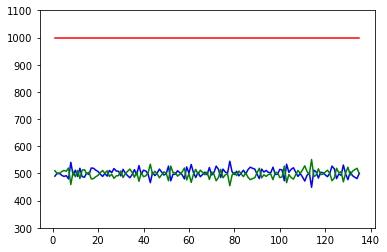

In [28]:
x=range(1,136)
plt.figure(figsize=(6, 4))
plt.ylim(300, 1100)
plt.plot(x, list11, color='blue') #Count of 11 measurements
plt.plot(x, list00, color='green') #Count of 00 measurements
plt.plot(x, list0011, color='red') #Count of 00 or 11 measurements

We can see that the no. of 00 states and the no. of 11 states is close to 500. <br>
However, these might be the states from 00-11 and not the correct 00+11 that we want. <br>
To check, we see the exact_statevector.

In [29]:
list00=[]
list11=[]
dd=defaultdict(int)
for i in aqb1:
    for j in aqb2:
        error_gates=["I","X","Z"]
        for qierror in error_gates:
            for qjerror in error_gates:
                circuit=bit_sign_circuit(i,qierror,j,qjerror)
                st=exact_statevector(circuit)
                dd[tuple(st)]+=1

In [30]:
dd

defaultdict(int, {('+00', '+11'): 117, ('+00', '-11'): 18})

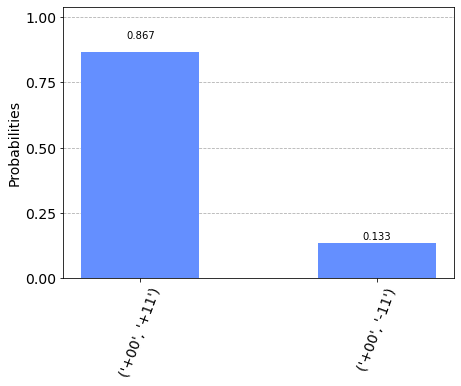

In [31]:
plot_histogram(dd)

Indeed some of the states were from 00-11 case. <br>
Hence, our circuit doesn't correct errors in test-2 i.e. where our Assumption-2 is removed. <br>
i.e. our circuit doesn't correct errors when ancillary qubits are also prone to error.

Our Soln 1 is failing on Test-2, so there's no need to test on test-3. We now move on to soln 2.

We now provide our next solution which uses 10 additional qubits.

### Section 4.2 : Error correction method using three Bit flip and two Sign flip code
Less efficient (but more robust wrt Assumptions) - (uses 10 additional qubits) <br>
This is our soln 2

We will add 8 ancillary qubits for 1st logical qubit. <br>
So we have 9 qubits corresponding to 1st logical qubit - [0,2,3,4,5,6,7,8,9] <br>
We were facing error in previous solution because bit flip errors were affecting our sign flip code's ancillary qubits. <br>
To solve that, we will add bit flip code to each of those ancillary qubits as well. <br>

We apply bitflip code to qubits 0,4 and 7. Then we apply signflipcode to 0 using qubits 4 and 7 as ancillary qubits. <br>

Actually, this setup of 3 bitflip codes and 1 signflip code is commonly known as "Shor Code" <br>

For the 2nd logical qubit, we keep the same signflip code as in the previous solution. <br>

Following figure shows our plan: <br>
<img src="images/55.png">

Note- Instead of using (3 Bit-flip + 1 Sign-flip code) i.e. (the Shor code) - 9 qubit code, we can also use a more efficient 5-qubit error correction code. However, the question specifies that we can only use Bitflip and Signflip codes, hence I will not discuss that here. <br>
You can find this 5 qubit error corrector code at - https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.77.198

In [32]:
def shorcode_before_error(): #Helper function for Shor code circuit BEFORE error operation. MADE USING BITFLIP+SIGNFLIP GATES
    circuit = QuantumCircuit(9)
    bitcode0=bitflip_before_error()
    signcode0=signflip_before_error()
    circuit=circuit.compose(signcode0,[0,3,6]) #Opening sign-flip code
    circuit=circuit.compose(bitcode0,[0,1,2]) #Opening Bit-flip code 1
    circuit=circuit.compose(bitcode0,[3,4,5]) #Opening Bit-flip code 2
    circuit=circuit.compose(bitcode0,[6,7,8]) #Opening Bit-flip code 3
    return circuit

In [33]:
def shorcode_after_error(): #Helper function for Shor code circuit AFTER error operation.MADE USING BITFLIP+SIGNFLIP GATES
    circuit = QuantumCircuit(9)
    bitcode1=bitflip_after_error()
    signcode1=signflip_after_error()
    circuit=circuit.compose(bitcode1,[6,7,8]) #Closing Bit-flip code 3
    circuit=circuit.compose(bitcode1,[3,4,5]) #Closing Bit-flip code 2
    circuit=circuit.compose(bitcode1,[0,1,2]) #Closing Bit-flip code 1
    circuit=circuit.compose(signcode1,[0,3,6]) #Closing Sign-flip code
    return circuit

In [34]:
#Helper function which -
#1) creates our initial circuit for bell states, 
#2) adds shor code to 1st qubit and bitflipcode to 2nd qubit
#3) adds desired error to the desired qubit
def create_shor_circuit(qbno1=-1,typeoferror1="I",qbno2=-1,typeoferror2="I"):
    circuit = QuantumCircuit(QuantumRegister(2,'q'))
    circuit.h(0) #Creating initial state
    shorcode1=shorcode_before_error()
    shorcode2=shorcode_after_error()
    circuit.add_register(QuantumRegister(8,'qs1'))
    circuit=circuit.compose(shorcode1,[0,2,3,4,5,6,7,8,9]) #Opening Shor code
    if qbno1>=0 and typeoferror1=="X":
        circuit.x(qbno1)
    elif qbno1>=0 and typeoferror1=="Z":
        circuit.z(qbno1) 
    circuit=circuit.compose(shorcode2,[0,2,3,4,5,6,7,8,9]) #Closing Shor code
    circuit.add_register(QuantumRegister(2,'qs2'))
    bitcode1=bitflip_before_error() 
    bitcode2=bitflip_after_error()
    circuit=circuit.compose(bitcode1,[1,10,11]) #Opening Bit-flip code
    if qbno2>=0 and typeoferror2=="X":
        circuit.x(qbno2)
    elif qbno2>=0 and typeoferror2=="Z":
        circuit.z(qbno2)  
    circuit=circuit.compose(bitcode2,[1,10,11]) #Closing Bit-flip code   
    #MAIN CNOT GATE
    circuit.cx(0,1)
    return circuit

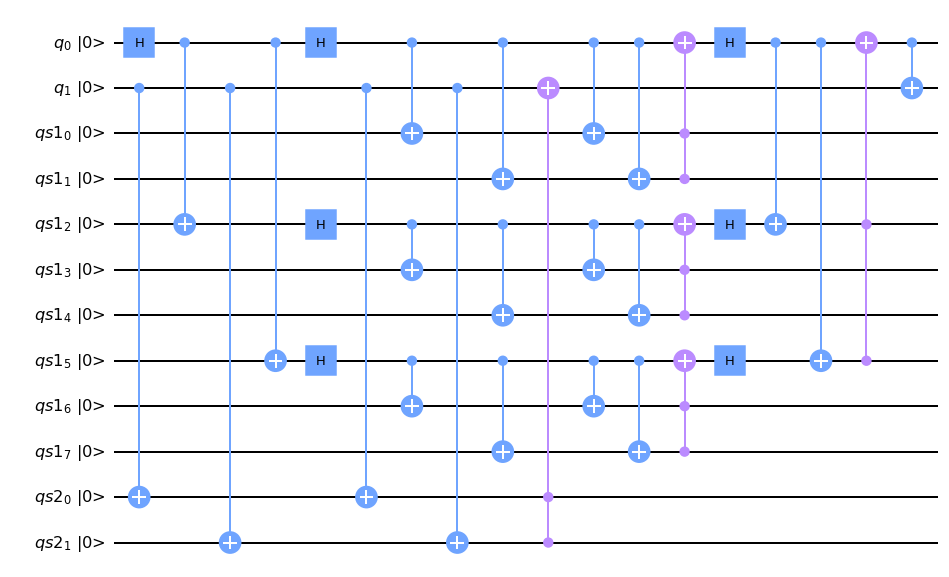

In [35]:
#Let's see the desired circuit
circuit=create_shor_circuit()
circuit.draw(initial_state=True, output="mpl")

In [36]:
aqb1=[0,2,3,4,5,6,7,8,9] #qubit nos. corresponding to Shor code
aqb2=[1,10,11] #qubit nos. corresponding to 2nd Bit-flip code

### Soln 2 : Test-1

Applying error I/X/Z to q_0 and q_1 and analyzing all such (3x3=9) combinations

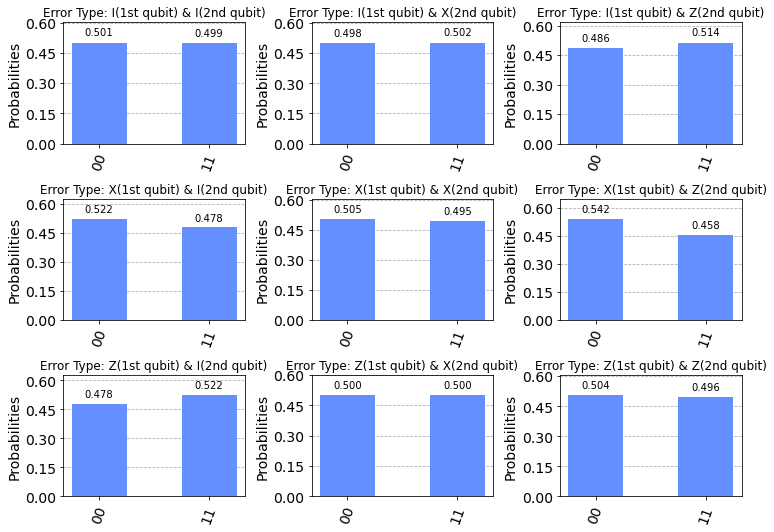

In [37]:
#Now we try all possible combinations of adding error to the two logical qubits 
#i.e. II,IX,IZ,XI,XX,XZ,ZI,ZX,ZZ
error_gates=["I","X","Z"]
fig=plt.figure(figsize=(10.5, 7.5))
idx=1
for q1error in error_gates:
    for q2error in error_gates: 
        circuit=create_shor_circuit(0,q1error,1,q2error)
        counts=get_counts(circuit)
        ax=fig.add_subplot(3,3,idx,title="Error Type: "+q1error+"(1st qubit) & "+q2error+"(2nd qubit)")
        plot_histogram(counts,ax=ax) 
        idx+=1
fig.tight_layout()
plt.show() 

However, once again we need to check the exact statevector to be sure that we are only getting 00+11 states.

In [38]:
error_gates=["I","X","Z"]
for q1error in error_gates:
    for q2error in error_gates: 
        circuit=create_shor_circuit(0,q1error,1,q2error)
        print(exact_statevector(circuit))

['+00', '+11']
['+00', '+11']
['+00', '+11']
['+00', '+11']
['+00', '+11']
['+00', '+11']
['+00', '+11']
['+00', '+11']
['+00', '+11']


Hence, we are getting correct results for Test-1.

### Soln 2 : Test-2

We now remove assumption-2 <br>
i.e.<br>
The error can now apply on ancillary qubits as well. <br>
Applying error I/X/Z to any qubit of 1st logical group of qubits (0,2,3,4,5,6,7,8,9) and any qubit of 2nd logical group of qubits (1,10,11) and analyzing all such (9x3x3x3=243) combinations

In [39]:
#Now we try all possible combinations of adding error to 9 qubits of 1st logical qubit and 3 qubits of 2nd logical qubit.
#i.e. 9 (no. of qubits in 1st group) x 3 (no. of error types) x 3 (no. of qubits in 2nd group) x 3 (no. of error types) = 243

list00=[] #List to add counts of 00 measurements
list11=[] #List to add counts of 11 measurements
for i in aqb1: #aqbi1 is already defined as the qubits corresponding to the 1st logical qubit
    for j in aqb2:
        error_gates=["I","X","Z"]
        for qierror in error_gates:
            for qjerror in error_gates:
                circuit=create_shor_circuit(i,qierror,j,qjerror)
                counts=get_counts(circuit)
                list00.append(counts["00"])
                list11.append(counts["11"])

In [40]:
len(list00)

243

In [41]:
x=range(1,244)
list0011=np.array(list00)+np.array(list11)
list00[:5]

[517, 495, 504, 522, 495]

In [42]:
list11[:5]

[483, 505, 496, 478, 505]

In [43]:
list0011[:5]

array([1000, 1000, 1000, 1000, 1000])

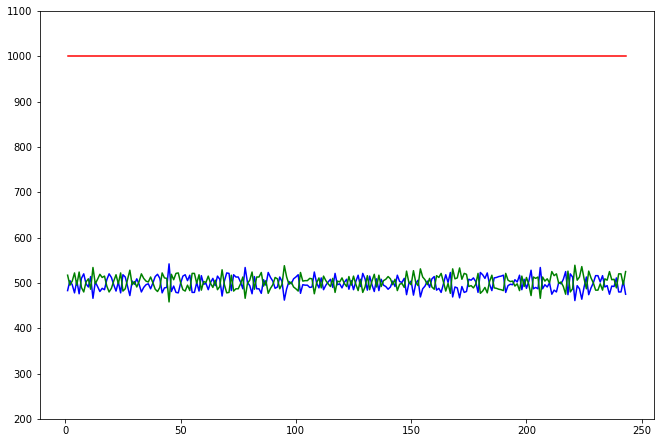

In [44]:
plt.figure(figsize=(11, 7.5))
plt.ylim(200, 1100)
plt.plot(x, list11, color='blue') #Count of 11 measurements
plt.plot(x, list00, color='green') #Count of 00 measurements
plt.plot(x, list0011, color='red') #Count of 00 or 11 measurements

We can see that the no. of 00 states and the no. of 11 states is close to 500.
However, these might be the states from 00-11 and not the correct 00+11 that we want.
To check, we see the exact_statevector.

In [45]:
list00=[]
list11=[]
dd=defaultdict(int)
for i in aqb1:
    for j in aqb2:
        error_gates=["I","X","Z"]
        for qierror in error_gates:
            for qjerror in error_gates:
                circuit=create_shor_circuit(i,qierror,j,qjerror)
                st=exact_statevector(circuit)
                dd[tuple(st)]+=1

In [46]:
dd

defaultdict(int, {('+00', '+11'): 243})

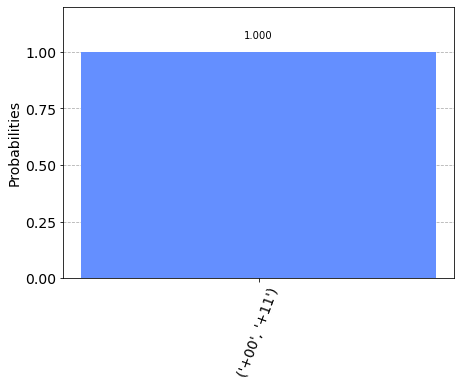

In [47]:
plot_histogram(dd)

So even after removing assumption-2, this time our error correction works perfectly.

### Soln 2 : Test-3
In Test-3, we even remove the assumption that only one qubit is affected by one error gate. <br>
Removing this assumption will not give us 100% accurate results (since it is an assumption of bit flip/sign flip codes itself) <br>
However, we will still get better results than not using an error correction circuit at all. (as long as p<0.5) <br>
We will compare the results of with and without error correction.

In [48]:
#Earlier we defined the function "create_shor_circuit" with errors I/X/Z.
#We now define the function "general_shor_circuit" which add a probability of inflicting an error instead of exact I/X/Z.
#Rest of the function is exactly same as the function "create_shor_circuit".
#Helper function which -
#1) creates our initial circuit for bell states, 
#2) adds corresponding codes to both our logical qubits
#3) adds desired error gates with desired probabilities

#px0=1st error gate bitflip probability
#pz0=1st error gate signflip probability
#px1=2nd error gate bitflip probability
#pz1=2nd error gate signflip probability
def general_shor_circuit(px0,pz0,px1,pz1):
    circuit = QuantumCircuit(QuantumRegister(2,'q'))
    circuit.h(0)
    shorcode1=shorcode_before_error()
    shorcode2=shorcode_after_error()
    circuit.add_register(QuantumRegister(8,'qs1'))
    circuit=circuit.compose(shorcode1,[0,2,3,4,5,6,7,8,9])  
    E1=pauli_error([('X',px0),('I',1-px0-pz0),('Z',pz0)], standard_gates=True)
    for i in [0,2,3,4,5,6,7,8,9]:
        circuit.append(E1, [i])   
    circuit=circuit.compose(shorcode2,[0,2,3,4,5,6,7,8,9])
    circuit.add_register(QuantumRegister(2,'qs2'))
    bitcode1=bitflip_before_error()
    bitcode2=bitflip_after_error()
    circuit=circuit.compose(bitcode1,[1,10,11])
    E2=pauli_error([('X',px1),('I',1-px1-pz1),('Z',pz1)], standard_gates=True)
    circuit.append(E2, [1])
    circuit.append(E2, [10])
    circuit.append(E2, [11])    
    circuit=circuit.compose(bitcode2,[1,10,11])   
    #MAIN CNOT GATE
    circuit.cx(0,1)
    return circuit

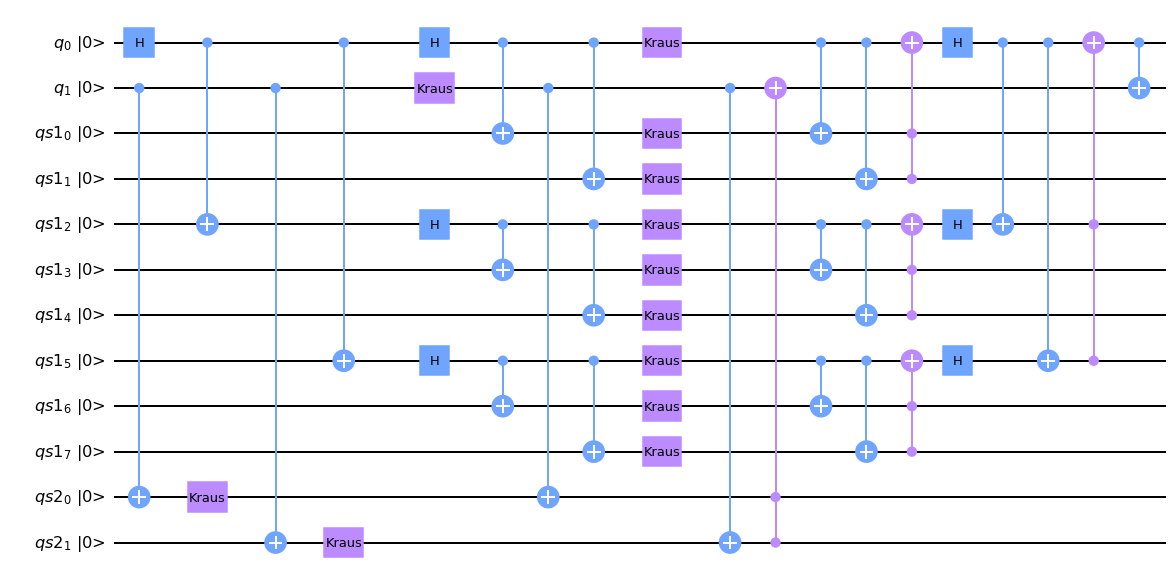

In [49]:
circuit=general_shor_circuit(px0=0.05,pz0=0.15,px1=0.14,pz1=0.06)
circuit.draw(initial_state=True, output="mpl")

In [50]:
counts=state_frequency(circuit) #runs the circuit 10000 times

In [51]:
counts

defaultdict(int,
            {('+00', '+11'): 9303,
             ('+01', '+10'): 480,
             ('+00', '-11'): 205,
             ('+01', '-10'): 12})

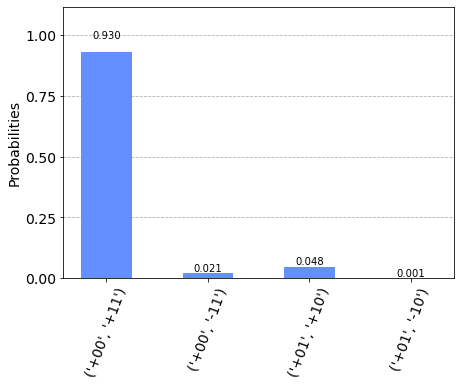

In [52]:
plot_histogram(counts)

In [53]:
#Comparing to "without error correction",
q=QuantumRegister(2,'q')
circuit = QuantumCircuit(q)
circuit.h(0)
E1=pauli_error([('X',0.05),('I',0.80),('Z',0.15)], standard_gates=True)
E2=pauli_error([('X',0.14),('I',0.80),('Z',0.06)], standard_gates=True)
circuit.append(E1, [0])
circuit.append(E2, [1])
circuit.cx(0,1)
counts2=state_frequency(circuit) #runs the circuit 10000 times
print(counts2)

defaultdict(<class 'int'>, {('+01', '-10'): 206, ('+00', '+11'): 7331, ('+00', '-11'): 1318, ('+01', '+10'): 1145})


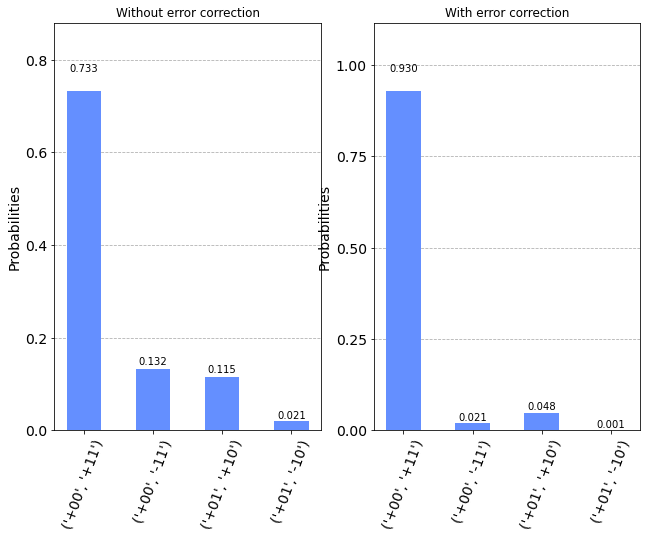

In [54]:
fig=plt.figure(figsize=(10.5, 7.5))
ax=fig.add_subplot(1,2,1,title="Without error correction")
plot_histogram(counts2,ax=ax)
ax=fig.add_subplot(1,2,2,title="With error correction")
plot_histogram(counts,ax=ax)

As can be seen, without error correction our accuracy is 73%. However with error correction, it goes up to 93% accurate.

## Section 5 - (Bonus Work) Efficient Error Detection

### 5.1 - An efficient method to detect error (using only 2 additional qubits)

We will use the following simple circuit
<img src="images/3.png">

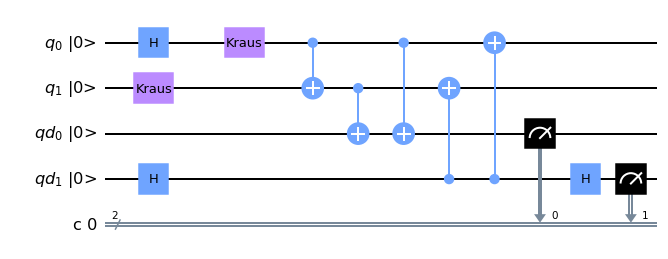

In [55]:
circuit = QuantumCircuit(QuantumRegister(2,'q'))
circuit.h(0)

E1=pauli_error([('X',0.25),('I',0.6),('Z',0.15)], standard_gates=True)
circuit.append(E1, [0])

E2=pauli_error([('X',0.21),('I',0.6),('Z',0.19)], standard_gates=True)
circuit.append(E2, [1])

circuit.cx(0,1)
circuit.add_register(QuantumRegister(2,'qd'))

circuit.cx(1, 2)
circuit.cx(0, 2)
circuit.h(3)
circuit.cx(3, 1)
circuit.cx(3, 0)

circuit.h(3)

c=ClassicalRegister(2,"c")
circuit.add_register(c)
circuit.measure(2,c[0])
circuit.measure(3,c[1])

circuit.draw(initial_state=True, output="mpl")

Based on the measured values of last 2 qubits (measured in the classical register), we can tell which error occured. <br>
We will get classical bits as follows: <br>
00 if no error occured <br>
01 if X on 2nd and no error on 1st qubit <br>
10 if Z on 1st and no error on 2nd qubit <br>
11 if both errors occured <br>

If we do many calculations, we should approach following values <br>
we should get no. of 00 = (1-Pz1) × Px2 = ((1-0.15)x(1-0.21)) = 0.6715 <br>
we should get no. of 01 = (1-Pz1) × Px2 = ((1-0.15)x0.21) = 0.1785 <br>
we should get no. of 10 = Pz1 × (1-Px2) = (0.15x(1-0.21)) = 0.118 <br>
we should get no. of 11 = Pz1 × Px2 = (0.15x0.21) = 0.0315 <br>

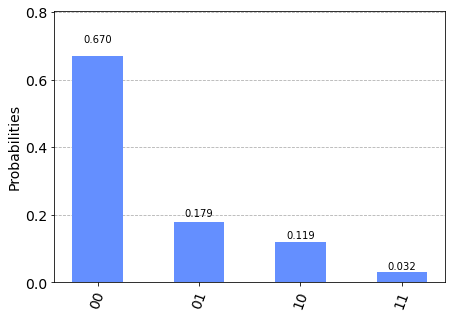

In [58]:
counts=state_count(circuit)
count_dict=defaultdict(int)
for i in counts:
    count_dict[i[:2]]+=counts[i] #Picking last two qubits
plot_histogram(count_dict)

We are getting the same number of different states as were expected (0.671, 0.179, 0.118, 0.0315) <br>
hence our error detection circuit seems to be working fine.

### Summary
1) Our 1st solution was efficient (only 6 additional qubits used). However, it can be used only when both assumptions 1 and 2 hold. <br>
2) Our 2nd solution was less efficient (uses 10 additional qubits). However, it was more robust and can be used when Assumption-2 doesn't hold. Moreover, when both assumptions don't hold, it still gives better results than not using any error correction code (as long as p<0.5).


### References <br>
[1] Quantum Error Correction - Wikipedia - https://en.wikipedia.org/wiki/Quantum_error_correction <br>
[2] Qiskit Documentation - https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.html

#### Further Reading Material <br>
[1] Perfect Quantum Error Correcting Code - https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.77.198 <br>

-Solution by Saksham Sarwari (sarwarisak@gmail.com)